Notebook to compare HYCOM and NOAA

In [1]:
import grab_HYCOM
import netCDF4 as nc

import matplotlib.pyplot as plt

from nowcast import analyze, residuals, figures
from nowcast.workers import get_NeahBay_ssh
import datetime
import numpy as np
from dateutil import tz
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style('darkgrid')
config = {'ssh': { 
        'tidal_predictions': '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/tidal_predictions/'
    }}

In [3]:
def NOAA_forcing_surge(date, config, run_type):

    filename_NB, run_date = analyze.create_path(run_type, date, 'ssh*.txt')
    data = residuals._load_surge_data(filename_NB)
    data_dates = np.array(data.date.values)
     # Check if today is Jan or Dec
    isDec, isJan = False, False
    if date.month == 1:
        isJan = True
    if date.month == 12:
        isDec = True
    for i in range(data_dates.shape[0]):
        data_dates[i] = get_NeahBay_ssh._to_datetime(data_dates[i], date.year, isDec, isJan)
    surge_NB, t_NB, _ = get_NeahBay_ssh._retrieve_surge(date, data_dates, data, config)
    dates_NB = [date+ datetime.timedelta(hours=float(t)) for t in t_NB]
    return surge_NB, dates_NB

In [4]:
def observed_surge(dates, config, comp_type):
    end = dates[-1]
    if comp_type =='recent':
        obs_prod = 'water_level'
        tide_prod = ''
    elif comp_type =='archived':
        obs_prod = 'hourly_height'
        tide_prod = 'h'
    obs = figures.get_NOAA_wlevels(
        figures.SITES['Neah Bay']['stn_no'], dates[0].strftime('%d-%b-%Y'), end.strftime('%d-%b-%Y'), 
        product=obs_prod
    )
    tides = figures.get_tides('Neah Bay', path=config['ssh']['tidal_predictions'])
    res_obs = residuals.calculate_residual(obs.wlev, obs.time, tides.pred_all, tides.time)
    return res_obs, obs.time

In [5]:
def HYCOM_forcing_surge(date):
    filename_HY = ('/ocean/nsoontie/MEOPAR/HYCOM/text/{}/'
        'hycom_1934_1661.txt'.format(date.strftime('%Y-%m-%d')))
    data, lon, lot = grab_HYCOM.parse_hycom_text(filename_HY)
    surge_HY = data['ssh']
    dates_HY = []
    for d in data['time']:
        d = d.to_datetime()
        dates_HY.append(d.replace(tzinfo=tz.tzutc()))
    surge_HY, dates_HY = analyze.truncate_data(np.array(surge_HY),np.array(dates_HY), 
                                               date ,date+datetime.timedelta(days=1) )
    return surge_HY, dates_HY

In [6]:
def observed_surge(dates, config, comp_type):
    end = dates[-1]
    if comp_type =='recent':
        obs_prod = 'water_level'
        tide_prod = ''
    elif comp_type =='archived':
        obs_prod = 'hourly_height'
        tide_prod = 'h'
    obs = figures.get_NOAA_wlevels(
        figures.SITES['Neah Bay']['stn_no'], dates[0].strftime('%d-%b-%Y'), end.strftime('%d-%b-%Y'), 
        product=obs_prod
    )
    tides = figures.get_tides('Neah Bay', path=config['ssh']['tidal_predictions'])
    res_obs = residuals.calculate_residual(obs.wlev, obs.time, tides.pred_all, tides.time)

    return res_obs, np.array(obs.time)

In [26]:
def compare_HYCOM_NOAA(dates, comp_type='recent'):
    """ 
    Compares the HYCMO and NOAA ssh anomaly forecasts for a dates in date.
    Observations are also plotted"""
    
    fig, axs = plt.subplots(3,1,figsize = (10,10))
    
    ssh_NOAA = np.array([]); time_NOAA = np.array([])
    ssh_HYCOM = np.array([]); time_HYCOM = np.array([])
    
    for date in dates:
        # get NOAA first
        try:
            surge_NB, dates_NB = NOAA_forcing_surge(date, config,'nowcast')
            ssh_NOAA = np.append(ssh_NOAA,surge_NB); 
            time_NOAA = np.append(time_NOAA, dates_NB)
        except IOError:
            print('No Salish Sea forecast on {}'.format(date.strftime('%Y-%m-%d')))
            
        # now get HYCOM
        try:
            surge_HY, dates_HY = HYCOM_forcing_surge(date)
            ssh_HYCOM= np.append(ssh_HYCOM,surge_HY)
            time_HYCOM = np.append(time_HYCOM, dates_HY)
        except IOError:
            print('HYCOM missing date {}'.format(date.strftime('%d-%b-%Y')) )
    
    #observations
    res_obs, obs_time = observed_surge(dates, config, comp_type)
    
    #plotting
    ax=axs[0]
    ax.plot(time_NOAA,ssh_NOAA,'.-',label = 'NOAA')
    ax.plot(time_HYCOM,ssh_HYCOM,'.-',label = 'HYCOM')
    ax.plot(obs_time,res_obs,'.-',label = 'Observations', alpha = 0.8)
    #labels etc
    ax.set_ylabel('SSH anomaly [m]')
    ax.legend(loc=0)
    ax.set_xlim([dates[0],dates[-1] +datetime.timedelta(days=1)])
    ax.set_title('Original data')
    
    #interpolate NOAA and obs to HYCOM times
    interp_NOAA = figures.interp_to_model_time(time_HYCOM, ssh_NOAA, time_NOAA)
    interp_obs = figures.interp_to_model_time(time_HYCOM, res_obs, obs_time)
    #plotting
    ax=axs[1]
    ax.plot(time_HYCOM,interp_NOAA,'.-',label = 'NOAA')
    ax.plot(time_HYCOM,ssh_HYCOM,'.-',label = 'HYCOM')
    ax.plot(time_HYCOM,interp_obs,'.-',label = 'Observations',alpha = 0.8)
    #labels etc
    ax.set_ylabel('SSH anomaly [m]')
    ax.legend(loc=0)
    ax.set_xlim([dates[0],dates[-1] +datetime.timedelta(days=1)])
    ax.set_title('Interoplated to HYCOM times')
    
    # Errors
    #plotting
    ax=axs[2]
    NOAA_error = np.array(interp_obs)- np.array(interp_NOAA)
    HYCOM_error = np.array(interp_obs) - np.array(ssh_HYCOM)
    ax.plot(time_HYCOM,NOAA_error,'.-',label = 'NOAA')
    ax.plot(time_HYCOM,HYCOM_error,'.-',label = 'HYCOM')
    #labels etc
    ax.set_ylabel('Error [m]')
    ax.legend(loc=0)
    ax.set_xlim([dates[0],dates[-1] +datetime.timedelta(days=1)])
    ax.set_title('Error (obs-model)')
    
    #analysis of error
    fig2, axs = plt.subplots(1,2,figsize=(10,3))
    errors = [NOAA_error, HYCOM_error]
    ax=axs[0]
    ax.boxplot(errors, labels=['NOAA', 'HYCOM'])
    ax.set_title('Errors')
    ax.legend(loc=0)
    ax=axs[1]
    abs_errors = [np.abs(NOAA_error), np.abs(HYCOM_error)]
    ax.boxplot(abs_errors, labels=['NOAA', 'HYCOM'])
    ax.set_title('Absolute Errors')
    ax.legend(loc=0)
    
    return fig, fig2

Note, I can only downlaoad 1 month of 6 minute NOAA data at a time. 

Also, hourly data isn't available right away because it needs to be verified. I have found that last week's hourly data is usually available, but not yesterday's or the day before. 

In [27]:
start  = datetime.datetime(2015,11,1); start = start.replace(tzinfo=tz.tzutc())
end = datetime.datetime(2015,11,30); end = end.replace(tzinfo=tz.tzutc())
numdays = (end-start).total_seconds()/86400
dates = [start + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]
print(dates[-1])

2015-11-30 00:00:00+00:00


HYCOM doesn't have the first time point but this may be an artifact of parsing.


# Latest water levels
Comparison with very recent prelimnary water levels from NOAA. Typcailly, we can only download one month of this data

HYCOM missing date 03-Nov-2015


/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


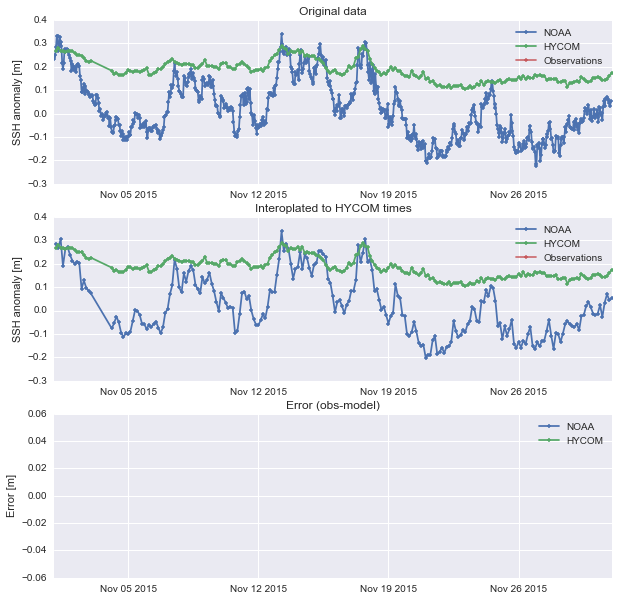

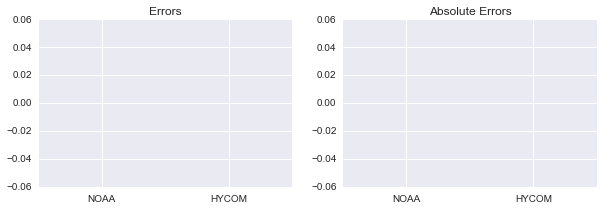

In [28]:
fig, fig2 = compare_HYCOM_NOAA(dates)

# Verfied water levels
Less recent, lower frequency data. Typically, many months are available the latest two weeks or so are not. 

HYCOM missing date 31-Jul-2015
HYCOM missing date 13-Sep-2015


/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


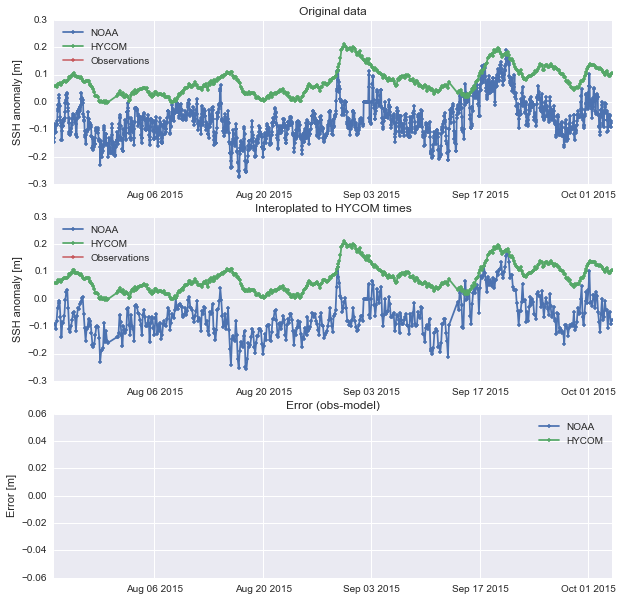

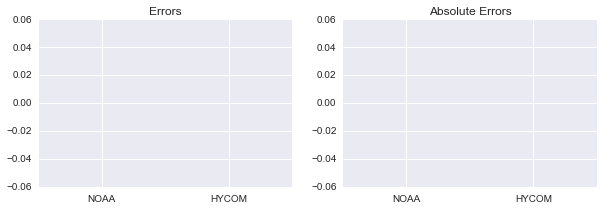

In [29]:

start  = datetime.datetime(2015,7,24); start = start.replace(tzinfo=tz.tzutc())
end = datetime.datetime(2015,10,3); end = end.replace(tzinfo=tz.tzutc())
numdays = (end-start).total_seconds()/86400
dates = [start + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]

fig, fig2 = compare_HYCOM_NOAA(dates, comp_type='archived')

In [46]:
date = datetime.datetime(2015,12,3);  date = date.replace(tzinfo=tz.tzutc())
import pandas as pd
surge_NB, time_NB = NOAA_forcing_surge(d, config, 'forecast')
df = pd.DataFrame({'surge': surge_NB, 'time': time_NB})

In [50]:
df['time_index'] = pd.DatetimeIndex(df['time'])
df = df.set_index('time_index')

In [51]:
surge_3hr = df.resample('3H')
surge_3hr = surge_3hr.reset_index()

In [52]:
surge_3hr

,time_index,surge
0,2015-12-03 00:00:00,0.208285
1,2015-12-03 03:00:00,0.174680
2,2015-12-03 06:00:00,0.186402
3,2015-12-03 09:00:00,0.196514
4,2015-12-03 12:00:00,0.240254
5,2015-12-03 15:00:00,0.245831
6,2015-12-03 18:00:00,0.168171
7,2015-12-03 21:00:00,0.169626


In [53]:
surge_HY, time_HY = HYCOM_forcing_surge(date)

In [54]:
surge_HY

array([ 0.31574038,  0.32864535,  0.34429812,  0.34142733,  0.34920704,
        0.36682823,  0.3721464 ,  0.37396213])

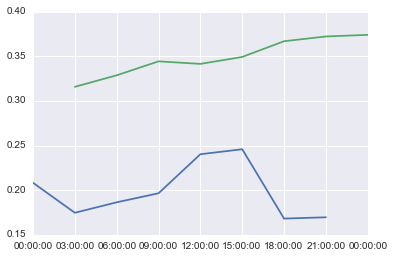

In [56]:
plt.plot(surge_3hr.time_index, surge_3hr.surge)
plt.plot(time_HY, surge_HY)

In [57]:
np.array(surge_3hr.time_index)

array(['2015-12-02T16:00:00.000000000-0800',
       '2015-12-02T19:00:00.000000000-0800',
       '2015-12-02T22:00:00.000000000-0800',
       '2015-12-03T01:00:00.000000000-0800',
       '2015-12-03T04:00:00.000000000-0800',
       '2015-12-03T07:00:00.000000000-0800',
       '2015-12-03T10:00:00.000000000-0800',
       '2015-12-03T13:00:00.000000000-0800'], dtype='datetime64[ns]')

In [58]:
surge_3hr.time_index

0   2015-12-03 00:00:00
1   2015-12-03 03:00:00
2   2015-12-03 06:00:00
3   2015-12-03 09:00:00
4   2015-12-03 12:00:00
5   2015-12-03 15:00:00
6   2015-12-03 18:00:00
7   2015-12-03 21:00:00
Name: time_index, dtype: datetime64[ns]